# Exercie 9:
## Part 1: 
Use the interpretation of the Laplacian operator for the heat equation presented in the PDE lecture to develop a cellular automata for heat transfer and diffusion models. Simulate the proposed model with various boundary conditions.

<IPython.core.display.Javascript object>


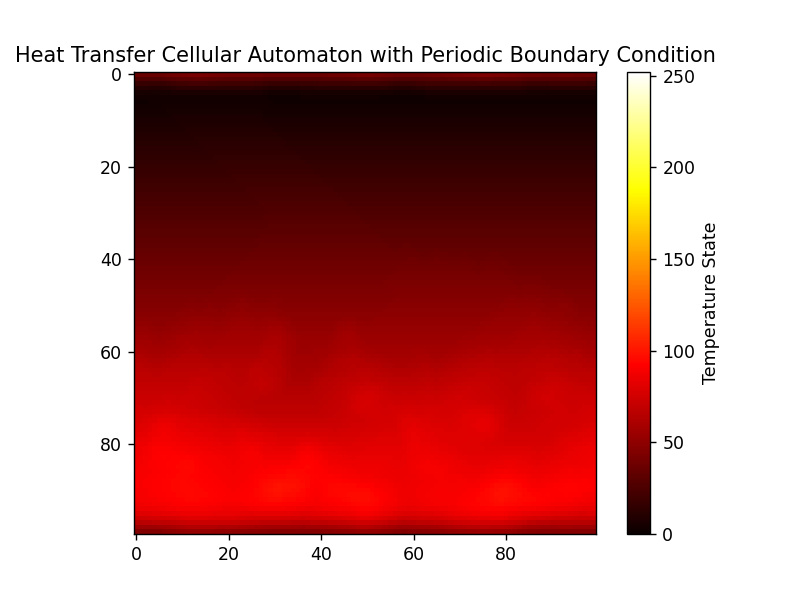

In [10]:
# Import the required libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook


# Initialize the grid
def init_grid(shape, init_method='random', **kwargs):
    '''
    The grid can be initialized using the following methods:
    *random: Set the cells to a random number.
    *linear_gradient: Set the temperature to increase linearly 
    from one side of the grid to the other.
    *random_gradient: Set the temperature to increase randomly
    from one side of the grid to the other.
    
    '''
    if init_method == 'random':
        return np.random.randint(num_states, size=shape)
    elif init_method == 'linear_gradient':
        rows, cols = shape
        return np.array([[i * (num_states - 1) // (cols - 1) for j in range(cols)] for i in range(rows)])
    elif init_method == 'random_gradient':
        rows, cols = shape
        return np.array([[np.random.randint(num_states) * i // (cols - 1) for j in range(cols)] for i in range(rows)])
    else:
        raise ValueError(f"Unsupported initialization method: {init_method}")

        
# Update rule
def update_rule(cell, neighbors, rule='mean'):
    '''
    The rules can be updated using the following methods:
    *mean: Set the cell's state to the average of the cell and 
    its neighboring.
    *max: Set the cell's state to the maximum temperature among
    the cell's own state and its neighbors.
    *laplacian: computes the Laplacian of the temperature field 
    at each cell by taking the difference between the cell's own 
    state and the weighted average of its neighbors, and updates 
    the cell's state based on the Laplacian.
    *gradient: computes the gradient of the temperature field 
    at each cell by taking the difference between the cell's 
    own state and the average of its neighbors, and updates the 
    cell's state based on the gradient.
    
    '''
    if rule == 'mean':
        return np.mean([cell] + neighbors)
    elif rule == 'max':
        return max([cell] + neighbors)
    elif rule == 'laplacian':
        return cell - 0.25 * (4 * cell - np.sum(neighbors))
    elif rule == 'gradient':
        return cell - 0.5 * (cell - np.mean(neighbors))
    else:
        raise ValueError(f"Unsupported rule: {rule}")

# Boundry conditions
def update_grid(grid, boundary, rule='mean'):
    '''
    The boundy condition can be defined as the following:
    *dirichlet, which is the default boundry condition.
    *neumann
    *periodic
    
    '''
    new_grid = np.zeros_like(grid)
    for i in range(grid.shape[0]):
        for j in range(grid.shape[1]):
            neighbors = []

            if i > 0:
                neighbors.append(grid[i - 1, j])
            elif boundary == 'neumann':
                neighbors.append(grid[i, j])
            elif boundary == 'periodic':
                neighbors.append(grid[-1, j])

            if i < grid.shape[0] - 1:
                neighbors.append(grid[i + 1, j])
            elif boundary == 'neumann':
                neighbors.append(grid[i, j])
            elif boundary == 'periodic':
                neighbors.append(grid[0, j])

            if j > 0:
                neighbors.append(grid[i, j - 1])
            elif boundary == 'neumann':
                neighbors.append(grid[i, j])
            elif boundary == 'periodic':
                neighbors.append(grid[i, -1])

            if j < grid.shape[1] - 1:
                neighbors.append(grid[i, j + 1])
            elif boundary == 'neumann':
                neighbors.append(grid[i, j])
            elif boundary == 'periodic':
                neighbors.append(grid[i, 0])

            new_grid[i, j] = update_rule(grid[i, j], neighbors, rule)
    return new_grid


# User inputs
grid_shape = (100, 100)
time_steps = 1000
num_states = 256
boundary = 'periodic'  # Choose from 'dirichlet', 'neumann', 'periodic'

# Initialize the grid 
grid = init_grid(grid_shape, init_method='random_gradient')

# Set up the plot for animation
fig, ax = plt.subplots()
im = ax.imshow(grid, cmap='hot', interpolation='nearest')
plt.colorbar(im, ax=ax, label='Temperature State')
plt.title('Heat Transfer Cellular Automaton with {} Boundary Condition'.format(boundary.capitalize()))

# Update function for the animation
def update(frame):
    global grid
    grid = update_grid(grid, boundary, rule='mean')
    im.set_array(grid)
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=time_steps, interval=50, blit=True)

# Display the animation
plt.show()


# Exercie 9:
## Part 2: 
Use cellular automata to model the propagation of cardiac contraction waves
within the myocardium. You may use a rectangular grid as shown in the case studies of this section, or a graph structure consisting of the SA node, the AV node, bundle of His, left and right bundle branches, and the Purkinje fibers.
#### I used a graph structure.

<IPython.core.display.Javascript object>


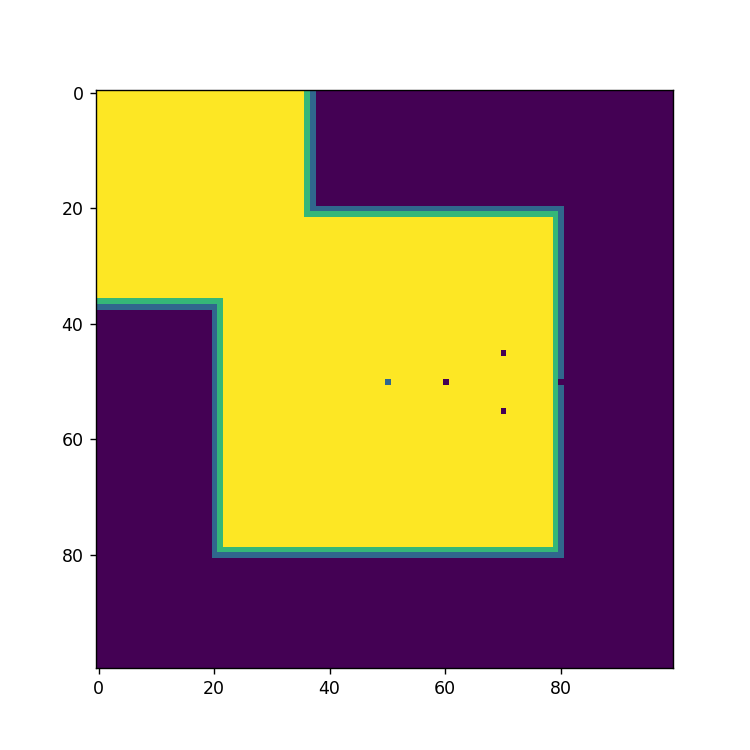

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
%matplotlib notebook

# Parameters
grid_size = 100
resting_state = 0
depolarizing_state = 1
repolarizing_state = 2
refractory_state = 3
refractory_time = 50

# Initialize lattice
lattice = np.zeros((grid_size, grid_size), dtype=int)

# Initialize graph structure (SA node, AV node, bundle of His, left and right bundle branches, Purkinje fibers)
graph_structure = {
    'SA_node': (5, 5),
    'AV_node': (grid_size // 2, grid_size // 2),
    'bundle_of_His': (grid_size // 2, grid_size // 2 + 10),
    'left_bundle_branch': (grid_size // 2 - 5, grid_size // 2 + 20),
    'right_bundle_branch': (grid_size // 2 + 5, grid_size // 2 + 20),
    'Purkinje_fibers': [(grid_size // 2 - i, grid_size // 2 + 30 + i) for i in range(20)] +
                       [(grid_size // 2 + i, grid_size // 2 + 30 + i) for i in range(20)]
}

# Set the initial state of the graph structure
lattice[graph_structure['SA_node']] = depolarizing_state

def update_lattice(lattice):
    new_lattice = lattice.copy()
    
    for x in range(grid_size):
        for y in range(grid_size):
            if lattice[x, y] == resting_state:
                depolarizing_neighbors = 0
                for dx in [-1, 0, 1]:
                    for dy in [-1, 0, 1]:
                        if 0 <= x + dx < grid_size and 0 <= y + dy < grid_size:
                            if lattice[x + dx, y + dy] == depolarizing_state:
                                depolarizing_neighbors += 1
                
                if depolarizing_neighbors > 0:
                    new_lattice[x, y] = depolarizing_state
            elif lattice[x, y] == depolarizing_state:
                new_lattice[x, y] = repolarizing_state
            elif lattice[x, y] == repolarizing_state:
                new_lattice[x, y] = refractory_state
            elif lattice[x, y] == refractory_state:
                new_lattice[x, y] = (lattice[x, y] + 1) % (refractory_time + 1)
                if new_lattice[x, y] == resting_state:
                    new_lattice[x, y] = resting_state
    
    # Update the graph structure
    new_lattice[graph_structure['AV_node']] = depolarizing_state if lattice[graph_structure['SA_node']] == repolarizing_state else lattice[graph_structure['AV_node']]
    new_lattice[graph_structure['bundle_of_His']] = depolarizing_state if lattice[graph_structure['AV_node']] == repolarizing_state else lattice[graph_structure['bundle_of_His']]
    new_lattice[graph_structure['left_bundle_branch']] = depolarizing_state if lattice[graph_structure['bundle_of_His']] == repolarizing_state else lattice[graph_structure['left_bundle_branch']]
    new_lattice[graph_structure['right_bundle_branch']] = depolarizing_state if lattice[graph_structure['bundle_of_His']] == repolarizing_state else lattice[graph_structure['right_bundle_branch']]
    
    for purkinje_fiber in graph_structure['Purkinje_fibers']:
        new_lattice[purkinje_fiber] = depolarizing_state if lattice[purkinje_fiber[0] - 1, purkinje_fiber[1] - 1] == repolarizing_state else lattice[purkinje_fiber]
    
    return new_lattice

# Animation
fig, ax = plt.subplots(figsize=(6, 6))
im = ax.imshow(lattice, cmap='viridis', vmin=resting_state, vmax=refractory_state)

def animate(frame):
    global lattice
    lattice = update_lattice(lattice)
    im.set_array(lattice)
    return [im]

ani = FuncAnimation(fig, animate, frames=200, blit=True, interval=100)
plt.show()
